In [1]:
from google.colab import files
uploaded = files.upload()

Saving breast-cancer.data to breast-cancer.data


In [2]:
!pip install miceforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.2 MB/s eta 0:00:00


In [118]:
import pandas as pd
from numpy import mean
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [76]:
def load():
  dataPath = "breast-cancer.data" #path cancer de mama
  data = pd.read_csv(dataPath, header=None)
  names = ["class","age","menopause","tumor_size","inv-nodes","node-caps","deg-malig","breast","breast-quad","irradiat"]
  data.columns = names

  data.replace('?', np.nan, inplace=True)

  print("BREAST CANCER MODEL PREDICTION (VERBOSE)")
  print("-"*100)
  print(data.info())
  print("-"*100)
  print(data.isna().sum())
  print("-"*100)

  X = data.drop("class", axis=1)
  y = data["class"]

  return (X, y)

In [74]:
def midpoint(r):
    lo, hi = map(int, re.findall(r'\d+', r))
    return (lo + hi) / 2

def oneHot(data, name):
  ohe = OneHotEncoder(drop="first", handle_unknown='error', sparse_output=False)
  encoded = ohe.fit_transform(data[[name]])
  encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([name]))
  df_encoded = pd.concat([data.drop(columns=[name]), encoded_df], axis=1)
  return df_encoded

def reEncode_no_ordinals_cols(X_data):
  X_data = oneHot(X_data, "menopause_encoded")
  X_data = oneHot(X_data, "breast-quad_encoded")
  return X_data

def ordinalEncode(data, name):
    encoder = OrdinalEncoder()
    encoded = encoder.fit_transform(data[[name]])
    encoded_df = pd.DataFrame(encoded, columns=[f"{name}_encoded"])
    df_encoded = pd.concat([data.drop(columns=[name]), encoded_df], axis=1)
    return df_encoded

def encodeX_Data_Numeric(X_data):
  X_data["age"] = X_data["age"].apply(lambda x: midpoint(x))
  X_data["tumor_size"] = X_data["tumor_size"].apply(lambda x: midpoint(x))
  X_data["inv-nodes"] = X_data["inv-nodes"].apply(lambda x: midpoint(x))
  return X_data

def encodeX_Data_Categorical_preOHE(X_data):
  X_data = ordinalEncode(X_data, "menopause")
  X_data['node-caps'] = X_data['node-caps'].map({'no': 0, 'yes': 1})
  X_data['breast'] = X_data['breast'].map({'left': 0, 'right': 1})
  X_data = ordinalEncode(X_data, "breast-quad")
  X_data['irradiat'] = X_data['irradiat'].map({'no': 0, 'yes': 1})
  return X_data

def encodeTarget(y_data):
  y = y_data.map({'no-recurrence-events': 0, 'recurrence-events': 1})
  return y

In [57]:
def dataImputation(data):
  imputer = IterativeImputer(random_state=42)
  df_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
  #Round the imputed values (those cols are cat.)
  df_imputed['node-caps'] = df_imputed['node-caps'].round().astype(int)
  df_imputed['breast-quad_encoded'] = df_imputed['breast-quad_encoded'].round().astype(int)

  return df_imputed

In [68]:
def encoderFunc(data):
  scaler = StandardScaler() #z-score scaling (mean and std. dev. needed)
  x_scaled = scaler.fit_transform(data)
  x_scaled = pd.DataFrame(x_scaled, columns=data.columns, index=data.index)
  return x_scaled

In [116]:
def lof(x_scaled, y_data):
  lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
  y_predict = lof.fit_predict(x_scaled)

  novelty_scores = -lof.negative_outlier_factor_
  print(novelty_scores)
  print("-"*100)
  threshold = np.percentile(novelty_scores, 90)
  print(threshold)
  print("-"*100)

  predicted_labels = np.where(y_predict==-1,1,0)
  anomaly_indices = np.where(predicted_labels==1)[0]

  #x_clean = np.delete(x_scaled, anomaly_indices, axis=0)
  x_clean = pd.DataFrame(x_scaled).drop(index=anomaly_indices).reset_index(drop=True)
  y_clean = pd.Series(y_data.values.ravel()).drop(index=anomaly_indices).reset_index(drop=True)

  return (x_clean, y_clean)

In [110]:
def supportVectorMachine_nestedCV(X, y):
  param_grid = [
      {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
      {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale', 'auto']},
      {'kernel': ['linear'], 'C': [0.1, 1, 10]},
  ]

  #Cross validation to test the model
  outerCV = KFold(n_splits=5, shuffle=True, random_state=12)
  svc = SVC(class_weight='balanced')

  test_score_nested = []
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []

  all_y_test = []
  all_y_pred = []

  plt.figure(figsize=(10, 8))

  for i, (train_index, test_index) in enumerate(outerCV.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    innerCV = KFold(n_splits=5, shuffle=True, random_state=i)
    model = GridSearchCV(estimator=svc, param_grid=param_grid, cv=innerCV)
    model.fit(X_train, y_train)
    print(f"Mejores hiper-parametros para fold {i}: {model.best_params_}")
    print(f"Mejor score para fold {i}: {model.best_score_}")

    y_pred_fold = model.predict(X_test)

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred_fold)

    precision = precision_score(y_test, y_pred_fold, pos_label=1) #we are gonna check the metrics based on malignant cases (target = 1)
    recall = recall_score(y_test, y_pred_fold, pos_label=1)
    f1 = f1_score(y_test, y_pred_fold, pos_label=1)
    acc = accuracy_score(y_test, y_pred_fold)

    print(f"Fold {i}: accuracy={acc:.2f}, precision={precision:.2f}, recall={recall:.2f}, f1-score={f1:.2f}")

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    test_score_nested.append(model.score(X_test, y_test))

  print("\n mean scores")
  print(f"Mean accuracy: {mean(accuracy_scores):.2f}")
  print(f"Mean precision: {mean(precision_scores):.2f}")
  print(f"Mean recall: {mean(recall_scores):.2f}")
  print(f"Mean f1-score: {mean(f1_scores):.2f}") #This is the most important metric to see the correct real malignant pred.

  print("\n test score en folds outer")
  for i, score in enumerate(test_score_nested):
    print(f"Fold {i}: test_score={score:.2f}")

  print("\n mean test score")
  print(f"Mean test score: {mean(test_score_nested):.2f}")

  final_conf_matrix = confusion_matrix(all_y_test, all_y_pred, labels=[0,1])
  print("\n confusion matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=[0,1])
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

In [114]:
def SVMglobalModel(X, y):
  param_grid = [
      {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
      {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale', 'auto']},
      {'kernel': ['linear'], 'C': [0.1, 1, 10]},
  ]
  best_model = GridSearchCV(estimator=SVC(class_weight='balanced'), param_grid=param_grid, cv=5)
  best_model.fit(X, y)
  print("Best global Hiperparams:", best_model.best_params_)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  all_y_test = []
  all_y_pred = []

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      model = best_model.best_estimator_
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      all_y_test.extend(y_test)
      all_y_pred.extend(y_pred)

  print(classification_report(all_y_test, all_y_pred, target_names=["Benign (0)", "Malignant (1)"]))

  cm = confusion_matrix(all_y_test, all_y_pred, labels=[0, 1])

  print("Confusion Matrix:")
  print(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix - SVM")
  plt.show()


In [128]:
def plotFeature(model,colN):
  for feature in zip(colN,model.feature_importances_):
    print(feature)
  sortedIdx=model.feature_importances_.argsort()
  colN=np.array(colN)
  plt.barh(colN[sortedIdx],model.feature_importances_[sortedIdx])
  plt.show()
  print(model.feature_importances_[sortedIdx])

In [120]:
def randomForest_best_HP(X, y, colN):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  nEst = [] # number of stimators (inner trees)
  for i in range(1,200,3):
    nEst.append(i)

  acc = [] # Accuracy
  oob_error = [] # out of bag --> to see the generalization error of the model

  print()
  for i in nEst:
    clf = RandomForestClassifier(n_estimators=i, oob_score=True, random_state=0)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    print(f"For {i} nEstimators -> Accuracy: {score:.2f}")
    acc.append(score)
    oob_error.append(1-clf.oob_score_)

  plt.figure(1)
  plt.plot(nEst,oob_error)
  plt.xlabel("number of trees")
  plt.ylabel("oob")
  plt.legend()
  index_max=max(range(len(acc)),key=acc.__getitem__)
  plt.figure(2)
  plotFeature(clf,colN)

In [132]:
def randomForest_CV_forHPs(X, y):
  param_grid = {
      'n_estimators': [13,103,37,50,52,100,130,133,200],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5],
      'max_features': ['sqrt', 'log2'],
      'class_weight': [None, 'balanced']
  }

  rf = RandomForestClassifier(oob_score=True, random_state=0)
  best_model = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
  best_model.fit(X, y)
  print("Best params:", best_model.best_params_)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  all_y_test = []
  all_y_pred = []

  for train_index, test_index in skf.split(X, y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      model = best_model.best_estimator_
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      all_y_test.extend(y_test)
      all_y_pred.extend(y_pred)

  print(classification_report(all_y_test, all_y_pred, target_names=["Benign (0)", "Malignant (1)"]))

  cm = confusion_matrix(all_y_test, all_y_pred, labels=[0, 1])

  print("Confusion Matrix:")
  print(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix - SVM")
  plt.show()


In [51]:
def printTable(data):
  col_widths = [max(len(str(val)) for val in [col] + data[col].astype(str).tolist()) for col in data.columns]

  header = " | ".join([str(col).ljust(width) for col, width in zip(data.columns, col_widths)])
  print(header)
  print("-" * len(header))

  for _, row in data.iterrows():
      row_str = " | ".join([str(row[col]).ljust(width) for col, width in zip(data.columns, col_widths)])
      print(row_str)


In [126]:
def main():
  X, y = load()
  printTable(X)

  #Clean the numeric data that are in ranges
  X_clean = encodeX_Data_Numeric(X)
  print()
  print("-"*100)
  print("CLEAN NUMERIC TABLE")
  printTable(X_clean)

  #Encode all the columns (cat. and bin. --> 0 or 1 for bin. and ordinal enc. for cat.)
  X_preImp = encodeX_Data_Categorical_preOHE(X_clean)
  print()
  print("-"*100)
  print("CAT. ENCODE (ORD.) TABLE")
  printTable(X_preImp)

  #Encode the target column
  y = encodeTarget(y)
  print()
  print("-"*100)
  print("TARGET TABLE")
  print(y)

  #MICE iterative imputing
  X_imp = dataImputation(X_preImp)
  print()
  print("-"*100)
  print("AFTER IMPUTING TABLE")
  printTable(X_imp)
  print()
  print("-"*100)
  print("AFTER IMPUTING MISSING DATA")
  print(X_imp.isna().sum())

  #Return the ordinal encoder to OHE (ordinal enc. was only used for imputation)
  X_OHE = reEncode_no_ordinals_cols(X_imp)
  print()
  print("-"*100)
  print("OHE ENOCDED TABLE")
  printTable(X_OHE)

  #Scaling data (better for SVM, not necessary for RF)
  X_scaled = encoderFunc(X_OHE)
  print()
  print("-"*100)
  print("SCALED DATA")
  printTable(X_scaled)

  #Detecting and deleting outliers (with LOF)
  pass

  #Nested Cross Validation to see the generalization of the SVM Model (acc )
  print()
  print("-"*100)
  print("SUPPORT VECTOR MACHINE (SVM) METRICS -NESTED CV-:")
  print()
  supportVectorMachine_nestedCV(X_scaled, y)
  print()

  #Selecting HPs with a simple GridSearch --> compare to nested
  print()
  print("-"*100)
  print("SUPPORT VECTOR MACHINE (SVM) BEST HPs WITH SIMPLE GRIDSEARCH:")
  print()
  SVMglobalModel(X_scaled, y)
  print()

  #Trying RF model to expect increase f1 (malignant detection)
  print()
  print("-"*100)
  print("RANDOM FOREST (RF) USING SCC AND OOB ERROR TO SELECT BEST N_TREES:")
  print()
  randomForest_best_HP(X_imp, y, X_imp.columns)

  #Selecting the best n_trees and use CV to select the best HPs for the model
  print()
  print("-"*100)
  print("RANDOM FOREST (RF) USING CV TO SELECT BEST HPS:")
  print()
  randomForest_CV_forHPs(X_imp, y)

BREAST CANCER MODEL PREDICTION (VERBOSE)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor_size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    278 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB
None
----------------------------------------------------------------------------------------------------
class          0
age            0
menopause      0
tumor_size     0
inv-nodes      0
node-caps      8
de

<Figure size 1000x800 with 0 Axes>

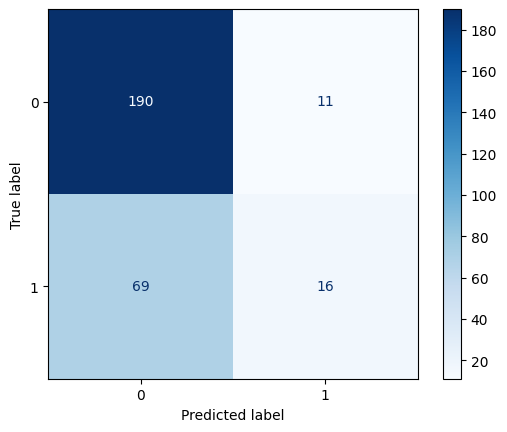



----------------------------------------------------------------------------------------------------
SUPPORT VECTOR MACHINE (SVM) BEST HPs WITH SIMPLE GRIDSEARCH:

Best global Hiperparams: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
               precision    recall  f1-score   support

   Benign (0)       0.73      0.94      0.82       201
Malignant (1)       0.55      0.19      0.28        85

     accuracy                           0.71       286
    macro avg       0.64      0.56      0.55       286
 weighted avg       0.68      0.71      0.66       286

Confusion Matrix:
[[188  13]
 [ 69  16]]


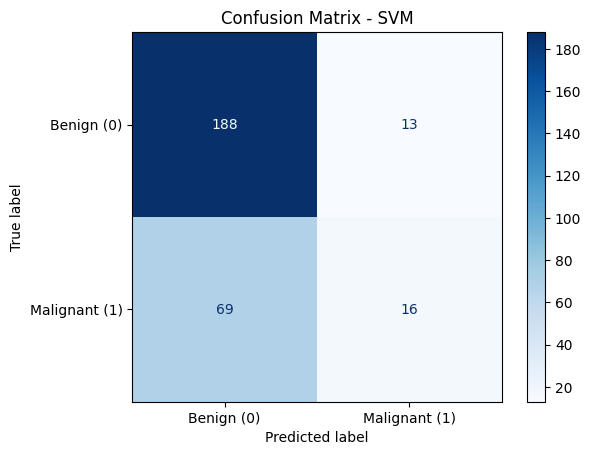



----------------------------------------------------------------------------------------------------
RANDOM FOREST (RF) USING SCC AND OOB ERROR TO SELECT BEST N_TREES:


For 1 nEstimators -> Accuracy: 0.72
For 4 nEstimators -> Accuracy: 0.67
For 7 nEstimators -> Accuracy: 0.71
For 10 nEstimators -> Accuracy: 0.64
For 13 nEstimators -> Accuracy: 0.72
For 16 nEstimators -> Accuracy: 0.66
For 19 nEstimators -> Accuracy: 0.69
For 22 nEstimators -> Accuracy: 0.69
For 25 nEstimators -> Accuracy: 0.67
For 28 nEstimators -> Accuracy: 0.67
For 31 nEstimators -> Accuracy: 0.67
For 34 nEstimators -> Accuracy: 0.66
For 37 nEstimators -> Accuracy: 0.67
For 40 nEstimators -> Accuracy: 0.64
For 43 nEstimators -> Accuracy: 0.67
For 46 nEstimators -> Accuracy: 0.67
For 49 nEstimators -> Accuracy: 0.67
For 52 nEstimators -> Accuracy: 0.71
For 55 nEstimators -> Accuracy: 0.69
For 58 nEstimators -> Accuracy: 0.69
For 61 nEstimators -> Accuracy: 0.69
For 64 nEstimators -> Accuracy: 0.69
For 67 nEstimator

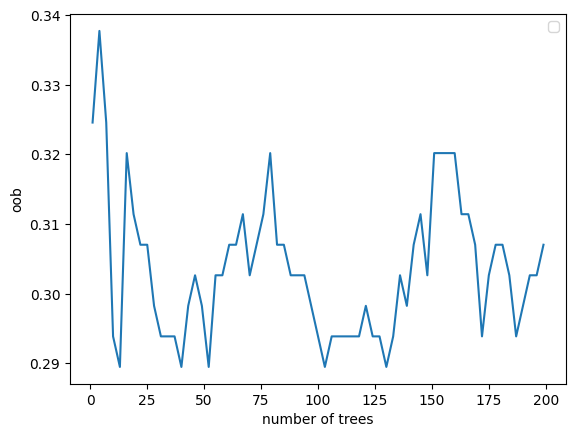

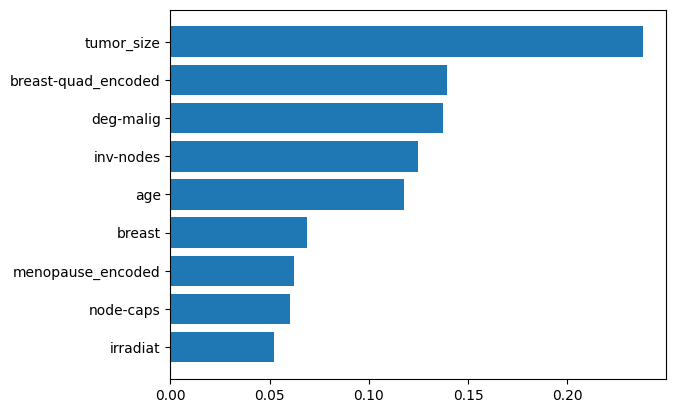

[0.05239585 0.06006135 0.06206167 0.06872653 0.11746288 0.1248902
 0.13711078 0.13931158 0.23797915]

----------------------------------------------------------------------------------------------------
RANDOM FOREST (RF) USING CV TO SELECT BEST HPS:

Best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
               precision    recall  f1-score   support

   Benign (0)       0.77      0.79      0.78       201
Malignant (1)       0.47      0.45      0.46        85

     accuracy                           0.69       286
    macro avg       0.62      0.62      0.62       286
 weighted avg       0.68      0.69      0.68       286

Confusion Matrix:
[[158  43]
 [ 47  38]]


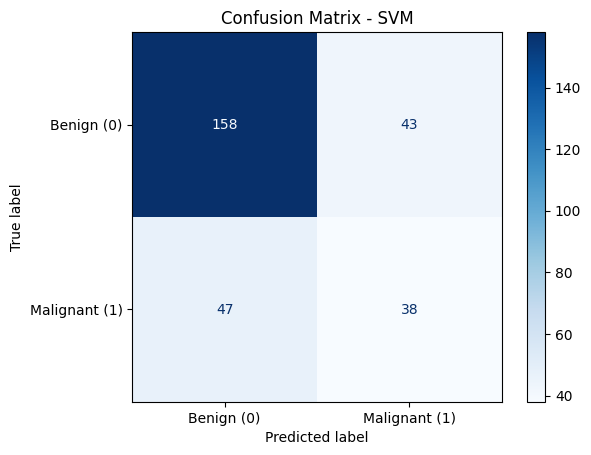

In [133]:
main()